In this workbook, we are going to build a model that interprets unknown temperature units into celcius. To do this, the model will adjust the weights of the model iteratively until a measure of error is low enough.

In [144]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [145]:
# THE DATA

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # temps in celcius

t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # temps in unknown unit

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Text(0, 0.5, 'celcius')

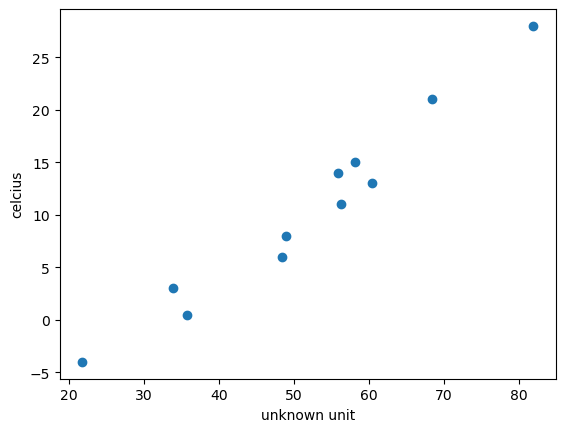

In [146]:
# plotting the data - looks like a linear relationship!
fig, ax = plt.subplots()
ax.scatter(t_u, t_c)
ax.set_xlabel('unknown unit')
ax.set_ylabel('celcius')

### Linear Relationships
Since we can see there is a linear relationship between the two data sets, we can map out a linear relationship:
$$celcius~=~w\times unknown~unit + b$$
We can stick to the terms *weight* and *bias* for *w* and *b*. These are the *parameters* in our model.

In [147]:
#writing our model as a function
def model(unknown_unit, w, b):
    return w * unknown_unit + b

## Loss Function
A *loss function* is a function that computes a single numerical value that the learning process will attempt to minimize. We need to ensure that the loss function returns a positive value for $predicted > actual$ and $predicted < actual$. For this we will use:
$$ (predicted - actual)^2$$
Since we are working with tensors, we will take the *mean square loss*. In other words, we subtract the tensors, then take their square *element wise* and then average the loss of all elements in the tensor.

In [148]:
#writing our mean-squared loss function
def loss_fn(predicted, actual):
    squared_diffs = (predicted - actual)**2
    return squared_diffs.mean()

### First forward pass

In [149]:
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [150]:
t_predicted = model(t_u, w, b)
t_predicted

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [151]:
# check the value of the loss
loss = loss_fn(t_predicted, t_c)
loss

tensor(1763.8848)

## Gradient Descent
The gradient descent algorithm computes the rate of change of the loss with respect to each parameter, and modifies each parameter in the direction of decreasing loss.

### Decreasing Loss - A crude way!
The below helps provide an intuition of how gradient descent works, but is not actually how it is implemented.

In [152]:
delta = 0.1 # the 'momentum' at which the algorithm will move

# the loss rate of change in respect to the parameter w
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w



tensor(4517.2974)

The above is measuring the loss difference between moving the parameter *w* one *delta* unit forward. In this case, the loss increases, meaning we need to decrease *w* to decrease the loss. <br><br>
We want to take this information and reassign a value to the parameter *w*. Since we want to decrease the variable *w* when we have a positive *loss rate of change*, we subtract the above from *w* to decrease *w*. This works both ways; if the *loss rate of change is negative*, then subtracting it from *w* will lead to an increase of *w*'s value.<br><br>
However, we also want to ensure we don't overshoot the optimal value for *w*. To ensure that we don't, we scale the *loss rate of change* by a factor that is called the ***learning rate***.

In [153]:
learning_rate = 1e-2

#updating the value of w
w = w - learning_rate * loss_rate_of_change_w

We do the same with the bias *b*.

In [154]:
# calculate the loss rate of change in respect to b
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

#update b based on the loss rate of change scaled by a learning rate
b = b - learning_rate * loss_rate_of_change_b


### Derivatives
For example, our loss function incorporates the below function. For sake of example, let's assume this is our entire loss function:
$$ (predicted - actual)^2$$
Which is plotted like this:<br><br>
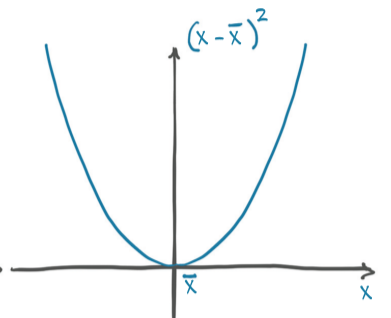

You could measure the *rate of change* between two x values in the above function. For example, given two x values, you can calculate the change in y over the change in x to get the slope. This rate of change is what we were calculating in the 'crude decreasing loss' section above. To find the minumum loss, if the *loss rate of change* (slope) is positive, we need to decrease the value of ouor variable, and if the *loss rate of change* (slope) is negative, we need to increase the value of our variable. <br><br> 
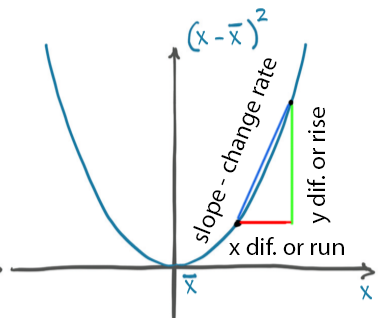


If you were to shrink that rise over run to an infintely small ratio, you could still determine a slope. This is the ***derivative***. It's also the tangent to the curve at a given point.<br><br>
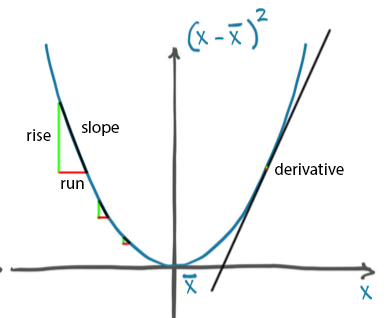
<br><br>
This is something I need to brush up on MUCH MORE, but the 20,000 ft. view is that you can combine derivatives (many of which are given in [handy tables](https://mathcentre.ac.uk/resources/Engineering%20maths%20first%20aid%20kit/latexsource%20and%20diagrams/8_2.pdf) ) using the *chain rule*. You can also solve for *partial derivatives* in respect for a certain variable in a function. All this being said, I need to study a lot more, but for right now, I know that given a loss function, you can find out whether you need to increase of decrease the given parameters (like *w* and *b*) to minimize the loss using derivatives (or more accurately *gradients*). You can do this for setting all parameters but one to be constants, and solve the *partial derivative* for said parameter.


### Gradients and Stochastic Gradient Descent
The derivative of a tensor operation is called a *gradient*. This is why our optimizer is called *stochastic gradient descent*. We are picking our initial parameters at random, then doing a forward pass, calculating our loss, and then doing a backwards pass by taking the gradient of our forward pass, and using the this information to tweak our parameters by a factor of our *learning rate* in the direction prescribed by the gradient.<br><br>
In reality, it's impossible to visualize this for a many-dimensioned tensor, but you can sort of visualize this process as finding the lowest point in a terrain.<br><br>
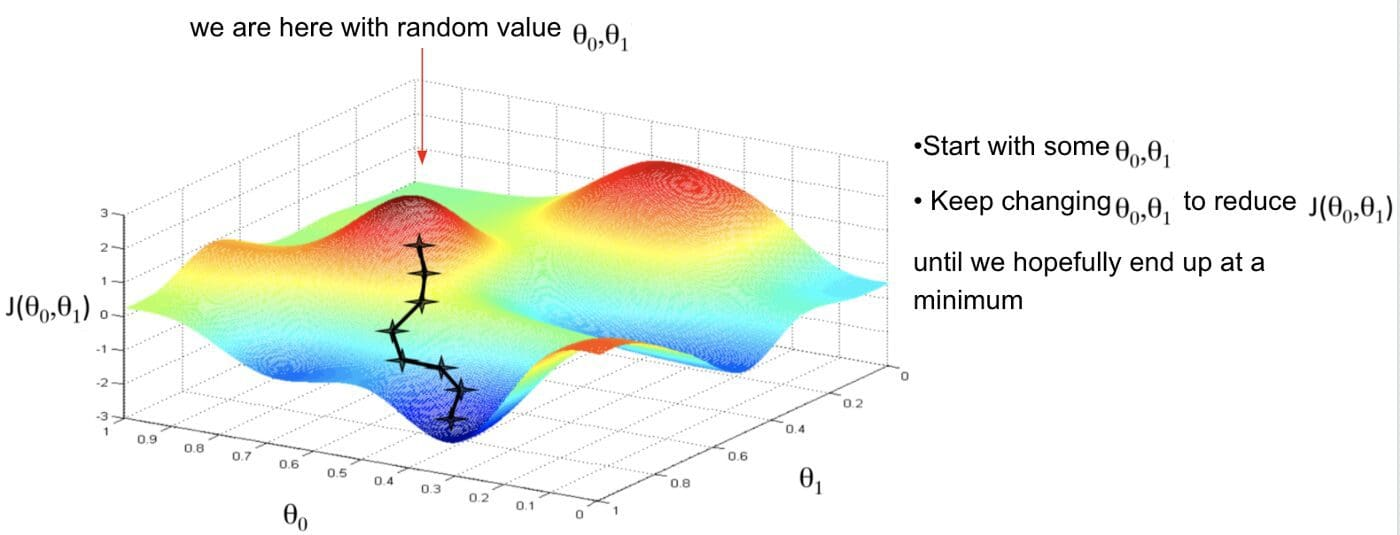

---
Back to following along with the book...

In [155]:
# taking the derivative of the loss function
def d_loss(predicted, actual):
    dsq_diffs = 2 * (predicted - actual) / predicted.size(0) #division is from derivative of mean
    return dsq_diffs

#derivative of model in respect to w
def d_model_w(unknown_unit, w, b):
    return unknown_unit

#derivative of model in respect to b
def d_model_b(unknown_unit, w, b):
    return 1.0

# returning the gradient of the loss with respect to w and b
def grad_fn(unknown_unit, actual, predicted, w, b):
    d_loss_unknown_actual = d_loss(predicted, actual)
    d_loss_w = d_loss_unknown_actual * d_model_w(unknown_unit, w, b)
    d_loss_b = d_loss_unknown_actual * d_model_b(unknown_unit, w, b)
    return torch.stack([d_loss_w.sum(), d_loss_b.sum()])

### The Training Loop
A training iteration during which we update the parameters for all of our training samples is called an *epoch*. For this first run, we will just run for a predefined number of epochs.


In [156]:
def training_loop(num_epochs, learning_rate, params, unknown_unit, celcius):

    # adding this to reduce the epoch loop vomiting!
    epoch_interval = num_epochs // 10

    for epoch in range(1, num_epochs + 1):
        w, b = params

        prediction = model(unknown_unit, w, b) # forward pass
        loss = loss_fn(prediction, celcius) # calculate loss
        gradient = grad_fn(unknown_unit, celcius, prediction, w, b) # backward pass

        params = params - learning_rate * gradient # updating the parameters

        if epoch % epoch_interval == 0:
            print(f'Epoch {epoch}, Loss {loss}')
    
    return params

In [157]:
# invoking the training loop
init_params = torch.tensor([1.0, 0.0]) # initial values of w and b

training_loop(num_epochs=100, learning_rate=1e-2, params=init_params, unknown_unit=t_u, celcius=t_c)

Epoch 10, Loss 9.090110518901907e+34
Epoch 20, Loss inf
Epoch 30, Loss nan
Epoch 40, Loss nan
Epoch 50, Loss nan
Epoch 60, Loss nan
Epoch 70, Loss nan
Epoch 80, Loss nan
Epoch 90, Loss nan
Epoch 100, Loss nan


tensor([nan, nan])

We can see from the above that our loss went to INFINITE! This is due to our `learning_rate` being too large and our model overshooting the target. Let's try again.

In [158]:
# invoking the training loop with a smaller learning_rate
init_params = torch.tensor([1.0, 0.0]) # initial values of w and b

training_loop(num_epochs=100, learning_rate=1e-4, params=init_params, unknown_unit=t_u, celcius=t_c)

Epoch 10, Loss 29.105247497558594
Epoch 20, Loss 29.09588050842285
Epoch 30, Loss 29.086713790893555
Epoch 40, Loss 29.07756233215332
Epoch 50, Loss 29.068401336669922
Epoch 60, Loss 29.059247970581055
Epoch 70, Loss 29.050098419189453
Epoch 80, Loss 29.04095458984375
Epoch 90, Loss 29.031810760498047
Epoch 100, Loss 29.022666931152344


tensor([ 0.2327, -0.0438])

The above behaviour is now stable, and we are converging towards a minimum loss. However, the updates to the parameters are very small so loss decreases slowly and eventually stalls. We can make some changes to our model to correct this.<br><br> 
### Normalizing Inputs
The learning rate will affect the parameters *w* and *b* differently since both are at much different scales. Assuming *w* is much larger than *b*, a tiny learning rate will work well for *b* but won't affect *w* much, whereas a large learning rate will affect *w* properly but will be unstable with *b*.<br><br>
To compensate for this, we can normalize the inputs so that all variables range from roughly -1.0 to 1.0. In this case, we can just multiply the unknown temperatures by 0.1.

In [159]:
# our unknown temperatues and celcius, not the difference
t_u, t_c

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]),
 tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
          6.0000, 13.0000, 21.0000]))

In [160]:
#bringing the unknown units closer to celcius
t_u_norm = t_u * 0.1
t_u_norm

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])

In [161]:
#trying out the training loop with the normalized unknown units
minimized_params = training_loop(num_epochs=5000, 
                                learning_rate=1e-2,
                                params=init_params,
                                unknown_unit=t_u_norm,
                                celcius=t_c)

Epoch 500, Loss 7.860115051269531
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.927680253982544
Epoch 4500, Loss 2.9276506900787354
Epoch 5000, Loss 2.927647590637207


The above gives us our minimized values for *w* and *b*! We can visualize these as a line since our model is in the form of $y = w\times x+b$

In [162]:
t_p = model(t_u_norm, *minimized_params) # getting the y values for the normalized unknown units
t_p

tensor([ 1.8593, 12.7008, 13.9352, 26.6552, 12.9155,  8.9439,  0.8932, -5.6009,
         8.6755, 15.1160, 19.4097])

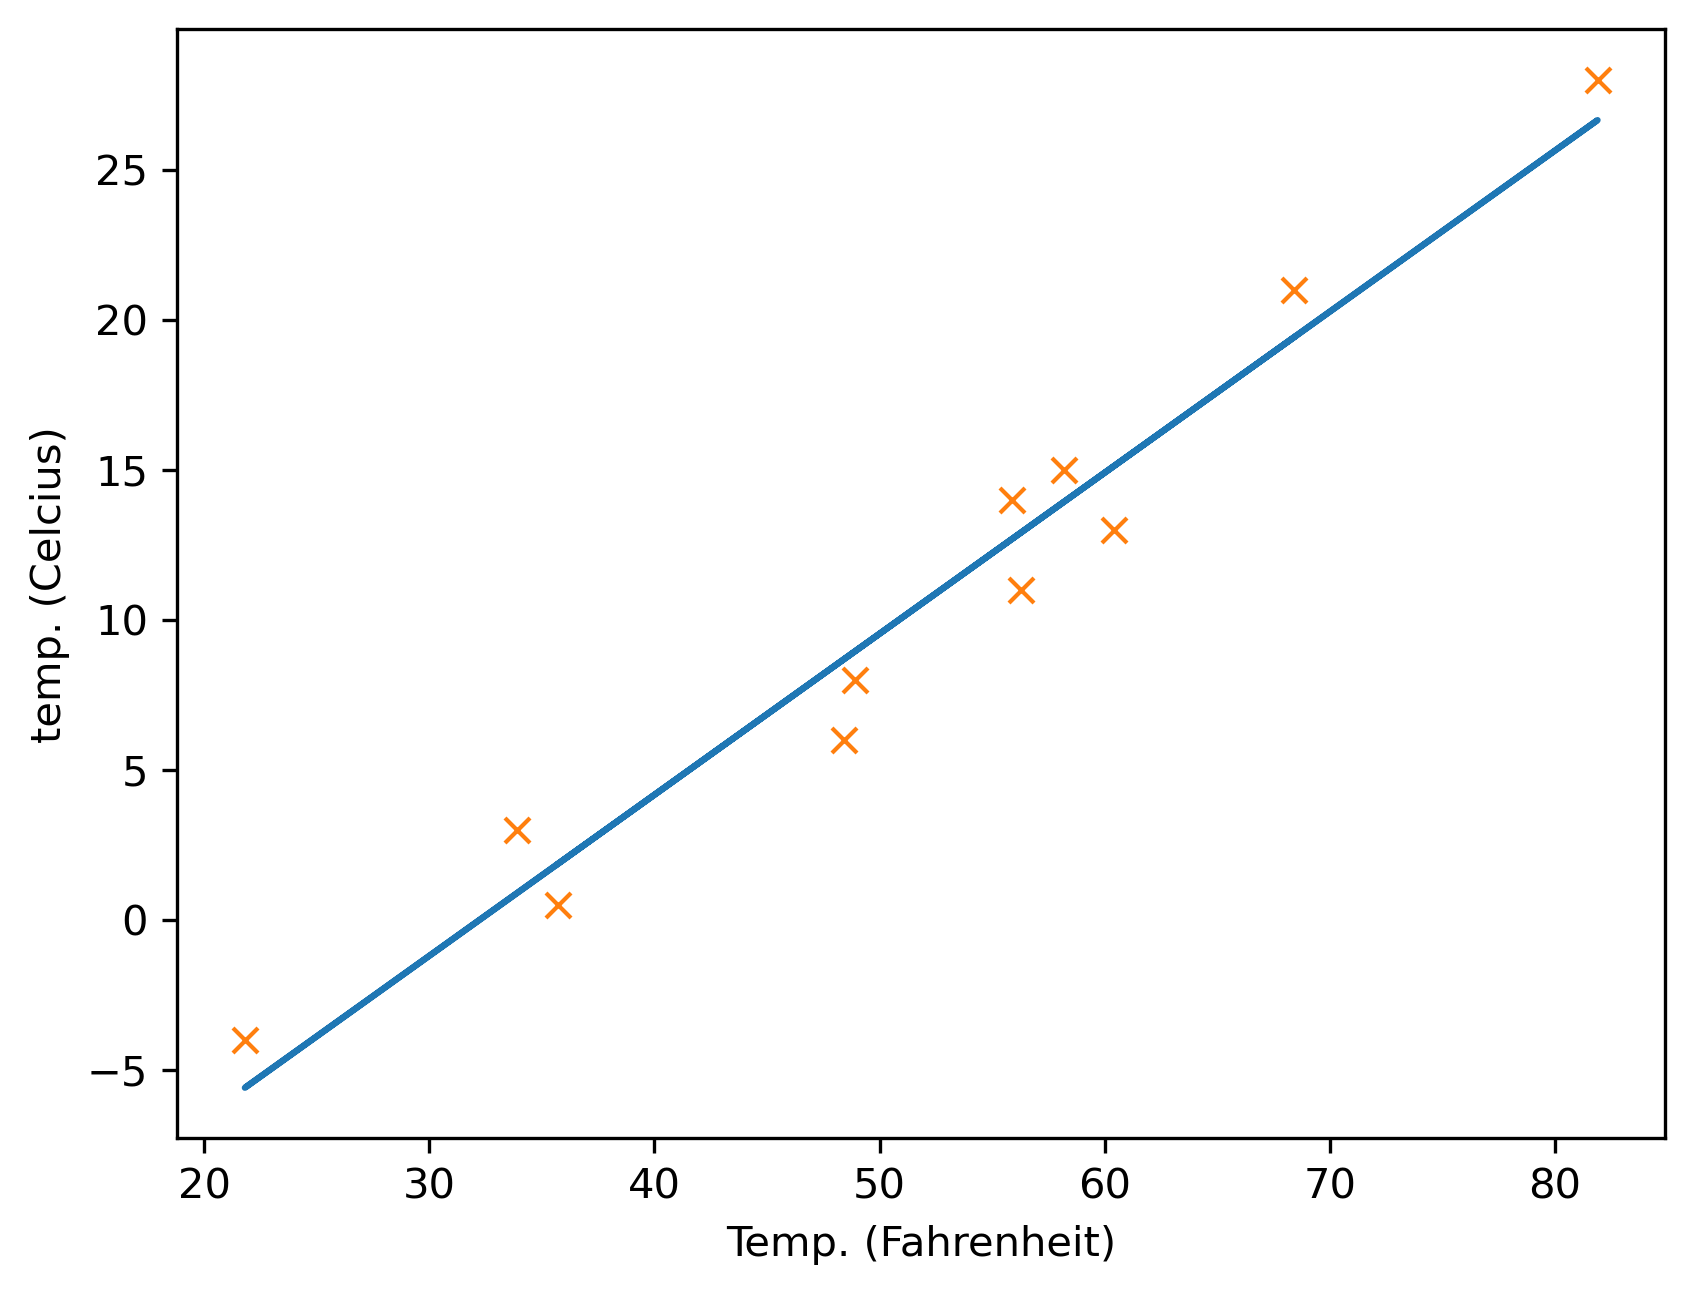

In [163]:
fig = plt.figure(dpi=300)
plt.xlabel("Temp. (Fahrenheit)")
plt.ylabel("temp. (Celcius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # plotting the line of our model
plt.plot(t_u.numpy(), t_c.numpy(), 'x')

## Autograd
Regardless of the amount of parameters, as long as a model is differentiable, we can compute the gradient of the loss with respect to the parameters. Of course this is impractical when you have 100s, 1000s, or 1000000s of parameters. PyTorch includes a component, *autograd* which can provide a gradient of an expression with respect to its parameters.

PyTorch tensors can *remember* where they came from. They can automatically provide the chain of derivatives of the operations and parent tensors that originiated them. To enable this behaviour we need to set the argument `requires_grad=True` in the `torch.tensor` constructor.

In [164]:
# re-initializing our parameters, but this time with autograd enabled
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [165]:
# without passing these doggies into a function, there will be no gradient to associated with the parameter tensor
# this will change in the code below
params.grad is None

True

All tensors that are ancestors of the parameter tensors with `requires_grad=True` will have access to the chain of functions that were called to get from the parameter tensor to that tensor. So, we can compute the backward pass on a descedent tensor and call the gradient from the initial parameter tensor. Like so:

In [166]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

When we compute our loss while the parameters `w` and `b` require gradients, in addition to performing the actual computation, PyTorch creates the autograd graph with the operations (in black circles) as nodes, as shown in the top row of the figure below. When we call `loss.backward()`, PyTorch traverses this graph in the reverse direction to compute the gradients, as shown by the arrows in the bottom row of the figure.<br><br>
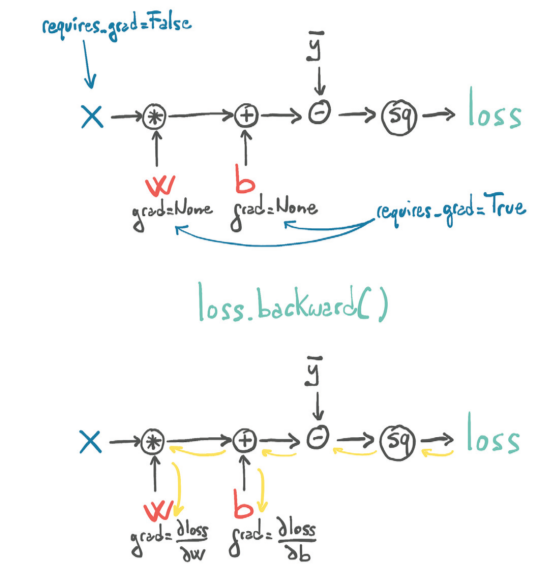

### WARNING ###
Calling `backward` causes the gradient to accumulate (aka add to what's already there) at the autograd graph. This will lead to an incorrect value for the gradient! To prevent this, we need to *zero the gradient explicitly* at each iteration. We do this with the in-place `zero_` method.<br><br>

Further, unless we are using a built in *optimizer* (which is usually the case), we need to tell PyTorch to ignore the calculations being done on the parameter tensor when we update it. To do this, we need to update the parameters tensor within a `no_grad` context. See below, but again, usually this functionality is hidden within a provided optimizer.

In [167]:
#the training loop using autograd enabled parameters
def training_loop(num_epochs, learning_rate, params, unknown_temps, celcius_temps):
    for epoch in range(1, num_epochs + 1):
        if params.grad is not None:
            params.grad.zero_() # zero the gradients for each pass

        temps_predicted = model(unknown_temps, *params) # running the forward pass
        loss = loss_fn(temps_predicted, celcius_temps) # calculating the loss
        loss.backward() # running the backward pass

        with torch.no_grad(): # tell PyTorch to look away!
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss}')
    
    return params

In [168]:
# re-initializing our parameters, but this time with autograd enabled
grad_params = torch.tensor([1.0, 0.0], requires_grad=True)


# running the training loop
training_loop(
    num_epochs = 5000,
    learning_rate = 1e-2,
    params = grad_params,
    unknown_temps = t_u_norm, # the normalized unknown temps
    celcius_temps = t_c)

Epoch 500, Loss 7.860115051269531
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.927651882171631
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers
We can look at the code we've writen above like so:<br><br>
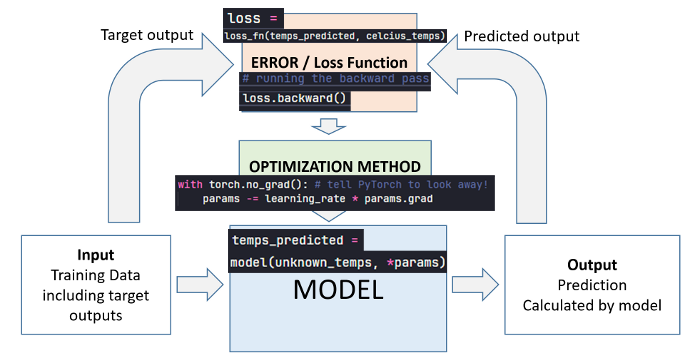
<br><br>
We have written our own optimizer by subtracting the *gradient* of the loss function in respect to the parameters scaled by the *learning rate*. PyTorch can do this for us! We can substitute the optimization step 
```
with torch.no_grad(): # tell PyTorch to look away!
            params -= learning_rate * params.grad
```

by defining an optimizer `optimizer = optim.SGD([params], lr=learning_rate)`, and then updating the parameters with the method `step()`. We still need to *zero the gradient* by calling the method `zero_grad()`. Our revised training loop will now look like this:

In [169]:
def training_loop(num_epochs, optimizer, params, temps_unknown, temps_celcius):
    for epoch in range(1, num_epochs + 1):
        temps_predicted = model(temps_unknown, *params) # forward pass with our model
        loss = loss_fn(temps_predicted, temps_celcius) # calc the loss

        optimizer.zero_grad() # zero the gradient if there is one (aka past the first epoch)
        loss.backward() # backward pass to calculate the gradient of the loss w/r to the parameters
        optimizer.step() # update the parameters using SGD

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss}')

In [170]:
# re-initializing our parameters, but this time with autograd enabled
grad_params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2

optimizer = torch.optim.SGD([grad_params], lr=learning_rate)

# running the training loop
training_loop(
    num_epochs = 5000,
    optimizer = optimizer,
    params = grad_params,
    temps_unknown = t_u_norm,
    temps_celcius = t_c
)

Epoch 500, Loss 7.860119819641113
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.927651882171631
Epoch 5000, Loss 2.9276468753814697
